In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

main_seed = 21

np.random.seed(main_seed)
random.seed(main_seed)
tf.random.set_seed(main_seed)

In [ ]:
drive.mount('/content/drive')

In [ ]:
base_path = '/content/drive/MyDrive/project4/IMDB'

In [ ]:
import pickle
import gzip

def load_data(file_name):
  global base_path
  with gzip.open(os.path.join(base_path, file_name), 'rb') as f:
    return pickle.load(f)

In [ ]:
# 파일 
print('X_train...')
X_train = load_data('X_train_word.pickle')
print('X_val...')
X_val = load_data('X_val_word.pickle')
print('X_test...')
X_test = load_data('X_test_word.pickle')

print('y_train...')
y_train = load_data('y_train.pickle')
print('y_val...')
y_val = load_data('y_val.pickle')
print('y_test...')
y_test = load_data('y_test.pickle')

print('embeddings...')
embeddings = load_data('embeddings.pickle')

print('max_seq_len...')
max_seq_len = load_data('max_len.pickle')

#### 기준모델

In [ ]:
import keras
import keras.backend as K
from keras.layers import Input, Embedding, LSTM, Lambda, concatenate, Dropout, Flatten, Dense, Bidirectional, GRU, Conv1D, GlobalMaxPooling1D, BatchNormalization, MaxPooling1D
from keras.models import Model
from keras import initializers
from sklearn.metrics import accuracy_score, f1_score

np.random.seed(main_seed)
tf.random.set_seed(main_seed)

In [ ]:
from scipy import stats

# 최빈 클래스 확인
mode_class = stats.mode(y_train)
print(mode_class)

In [20]:
y_pred = [mode_class[0]] * len(y_val)
print('val accuracy:', accuracy_score(y_val, y_pred))
print('val f1_score:', f1_score(y_val, y_pred))

val accuracy: 0.7735757050361661
val f1_score: 0.0


#### 1.Mamhattan LSTM

In [ ]:
def exponent_neg_manhattan_distance(left, right):
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [ ]:
def create_ManLSTM(max_seq_len):

  # summary와 review 각각 입력 받기
  left_input= Input((max_seq_len, ))
  right_input = Input((max_seq_len, ))

  # 임베딩
  embedding_layer = Embedding(len(embeddings),
                              300,
                              weights=[embeddings],
                              input_length=max_seq_len,
                              trainable=False,
                              embeddings_initializer=initializers.glorot_uniform(seed=main_seed))
  left_encoded = embedding_layer(left_input)
  right_encoded = embedding_layer(right_input)

  # lstm
  lstm_layer = LSTM(50,
                    kernel_initializer=initializers.glorot_uniform(seed=main_seed))
  left_output = lstm_layer(left_encoded)
  right_output = lstm_layer(right_encoded)

  # exponent_neg_manhattan_distance 계산 (-> 0 ~ 1 사이의 값)
  distance = Lambda(function = lambda x: exponent_neg_manhattan_distance(x[0], x[1]),
                    output_shape = lambda x: (x[0][0], 1)
                    )([left_output, right_output])

  model = Model([left_input, right_input], [distance])
  return model

In [ ]:
# 아담 옵티마이저

manlstm = create_ManLSTM(max_seq_len)

manlstm.compile(optimizer = 'Adam', 
                loss='mean_squared_error', 
                metrics=['accuracy'])

In [ ]:
manlstm.summary()

In [ ]:
# early_stop
def set_callbacks(model_name):
  early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=2)
  return early_stop

In [14]:
tf.random.set_seed(main_seed)

early_stop = set_callbacks('ManLSTM')

manlstm_trained = manlstm.fit(
    [X_train['summary'], X_train['review']],
    y_train,
    batch_size=1021,
    epochs=10,
    validation_data=([X_val['summary'], X_val['review']], y_val),
    callbacks=[early_stop]);

Epoch 1/10
217/217 [==============================] - 1057s 5s/step - loss: 0.2072 - accuracy: 0.7728 - val_loss: 0.1794 - val_accuracy: 0.7733
Epoch 2/10
217/217 [==============================] - 1140s 5s/step - loss: 0.1778 - accuracy: 0.7728 - val_loss: 0.1750 - val_accuracy: 0.7734
Epoch 3/10
217/217 [==============================] - 1131s 5s/step - loss: 0.1735 - accuracy: 0.7730 - val_loss: 0.1731 - val_accuracy: 0.7737
Epoch 4/10
217/217 [==============================] - 1118s 5s/step - loss: 0.1705 - accuracy: 0.7739 - val_loss: 0.1681 - val_accuracy: 0.7744
Epoch 5/10
217/217 [==============================] - 1095s 5s/step - loss: 0.1641 - accuracy: 0.7762 - val_loss: 0.1624 - val_accuracy: 0.7763
Epoch 6/10
217/217 [==============================] - 1078s 5s/step - loss: 0.1583 - accuracy: 0.7799 - val_loss: 0.1607 - val_accuracy: 0.7783
Epoch 7/10
217/217 [==============================] - 1126s 5s/step - loss: 0.1572 - accuracy: 0.7792 - val_loss: 0.1590 - val_accuracy:

In [16]:
%%time

y_pred = manlstm.predict([X_val['summary'], X_val['review']])
y_pred_class = np.array([1 if value > 0.5 else 0 for value in y_pred])

print('val accuracy:', accuracy_score(y_val, y_pred_class))
print('val f1_score:', f1_score(y_val, y_pred_class))

val accuracy: 0.7775038604285753
val f1_score: 0.2575483637678539
CPU times: user 9min 49s, sys: 43 s, total: 10min 32s
Wall time: 3min 10s


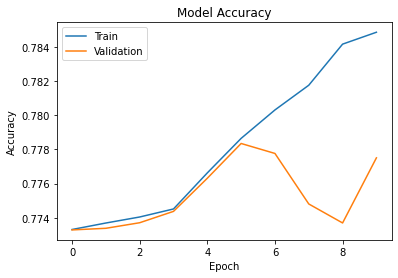

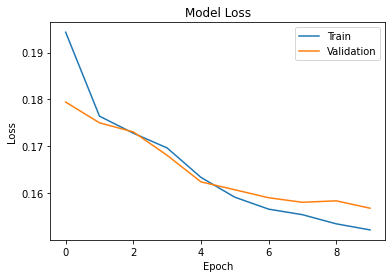

In [18]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(manlstm_trained.history['accuracy'])
plt.plot(manlstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(manlstm_trained.history['loss'])
plt.plot(manlstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()